**Packages**

In [1]:
using CSV, DataFrames
using Statistics
using GLMakie
GLMakie.activate!(inline=true)
using ProgressMeter


**Plot the process**

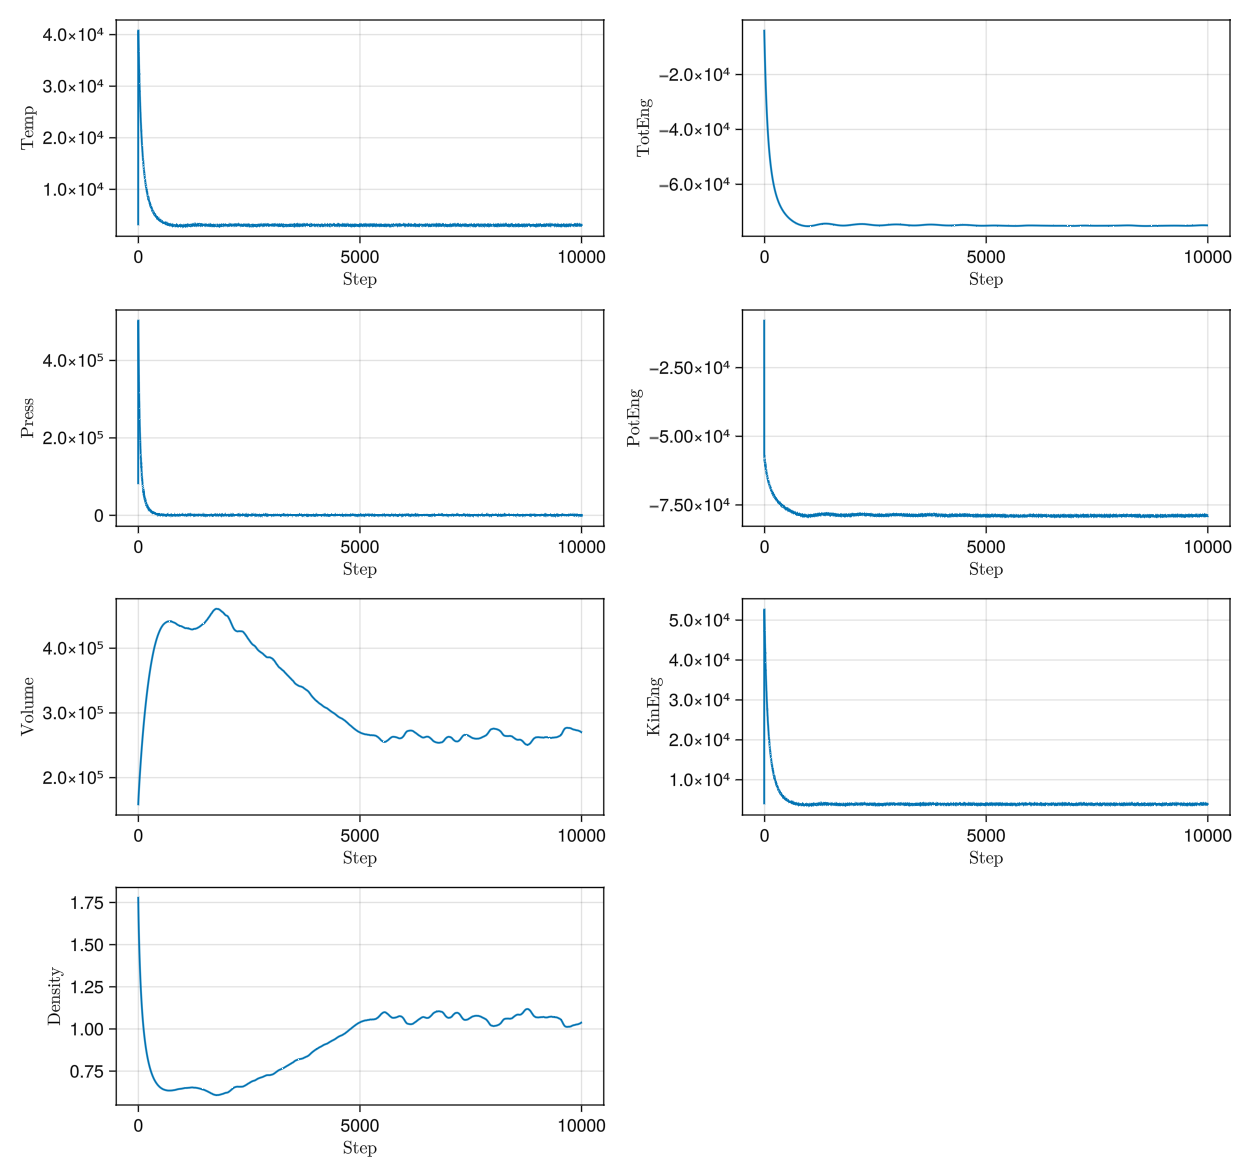

In [2]:
df = CSV.read("process.txt", DataFrame; delim=' ', ignorerepeated=true);
first(df, 5)
fig = Figure(size=(1000, 1000))

ax1 = Axis(fig[1,1], ylabel=L"\text{Temp}", xlabel=L"\text{Step}")
ax2 = Axis(fig[2,1], ylabel=L"\text{Press}", xlabel=L"\text{Step}")
ax3 = Axis(fig[3,1], ylabel=L"\text{Volume}", xlabel=L"\text{Step}")
ax4 = Axis(fig[4,1], ylabel=L"\text{Density}", xlabel=L"\text{Step}")
ax5 = Axis(fig[1,2], ylabel=L"\text{TotEng}", xlabel=L"\text{Step}")
ax6 = Axis(fig[2,2], ylabel=L"\text{PotEng}", xlabel=L"\text{Step}")
ax7 = Axis(fig[3,2], ylabel=L"\text{KinEng}", xlabel=L"\text{Step}")

lines!(ax1,df.Temp)
lines!(ax2,df.Press)
lines!(ax3,df.Volume)
lines!(ax4,df.Density)
lines!(ax5,df.TotEng)
lines!(ax6,df.PotEng)
lines!(ax7,df.KinEng)

fig

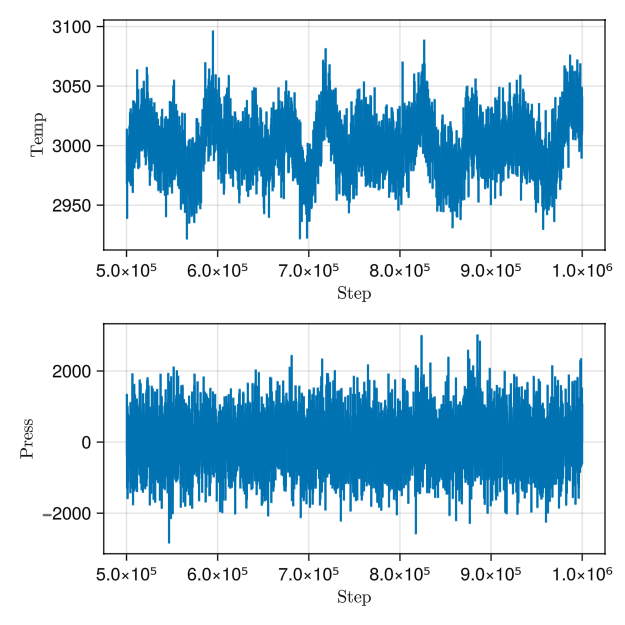

In [3]:
fig = Figure(size=(500, 500))
ax1 = Axis(fig[1,1], ylabel=L"\text{Temp}", xlabel=L"\text{Step}")
ax2 = Axis(fig[2,1], ylabel=L"\text{Press}", xlabel=L"\text{Step}")
lines!(ax1, df.Step[(nrow(df) ÷ 2) + 1:end],  df.Temp[(nrow(df) ÷ 2) + 1:end])
lines!(ax2, df.Step[(nrow(df) ÷ 2) + 1:end],  df.Press[(nrow(df) ÷ 2) + 1:end])
fig

**Plots the particles**

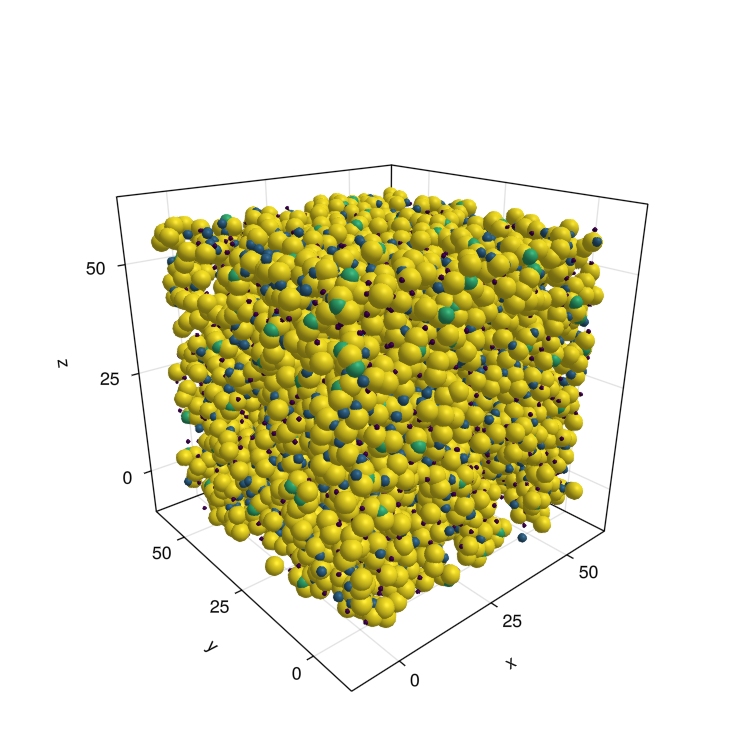

In [4]:
df = CSV.File("coordinate.txt", delim=' ', ignorerepeated=true, header=false) |> DataFrame
rename!(df, ["type", "x", "y", "z"])
first(df, 5)

# Plot the atoms:
aspect=(1, 1, 1)
perspectiveness=0.5
# the figure
fig = Figure(; size=(600, 600))
ax1 = Axis3(fig[1, 1]; aspect, perspectiveness)
meshscatter!(ax1, df.x, df.y, df.z; markersize=df.type/2, color=df.type)
fig

**Plot the RDF**

In [5]:
# function dist(x1, y1, z1, x2, y2, z2, lx, ly, lz)
#     rx = x1 - x2
#     ry = y1 - y2
#     rz = z1 - z2
#     rx = rx > lx / 2 ? rx - lx : (rx < -lx / 2 ? rx + lx : rx)
#     ry = ry > ly / 2 ? ry - ly : (ry < -ly / 2 ? ry + ly : ry)
#     rz = rz > lz / 2 ? rz - lz : (rz < -lz / 2 ? rz + lz : rz)
#     return √(rx^2 + ry^2 + rz^2)
# end
function dist(x1, y1, z1, x2, y2, z2, lx, ly, lz)
    rx = x1 - x2
    if rx > lx / 2
        rx -= lx
    elseif rx < -lx / 2
        rx += lx
    end

    ry = y1 - y2
    if ry > ly / 2
        ry -= ly
    elseif ry < -ly / 2
        ry += ly
    end

    rz = z1 - z2
    if rz > lz / 2
        rz -= lz
    elseif rz < -lz / 2
        rz += lz
    end

    return sqrt(rx^2 + ry^2 + rz^2)
end

dist (generic function with 1 method)

In [6]:
nunit = 1111
nna, nli, nsi, noxy = 2, 2, 1, 4
dna = df[1:nunit * nna, :]
dli = df[(nunit * nna + 1):(nunit * (nna + nli)), :]
dsi = df[(nunit * (nna + nli) + 1):(nunit * (nna + nli + nsi)), :]
doxy = df[(nunit * (nna + nli + nsi) + 1):end, :];

In [13]:
function calc_coordination(df, type1, type2, cut_off)
    l = maximum(df.x), maximum(df.y), maximum(df.z);
    coordination_numbers = []
    # Loop through each silicon atom
    @showprogress for i in 1:nrow(df)
        if df.type[i] == type1  # Assuming type 1 represents Si
            count = 0
            # Loop through each atom to find oxygen neighbors
            for j in 1:nrow(df)
                if df.type[j] == type2  # Assuming type 3 represents O
                    d = dist(df.x[i], df.y[i], df.z[i], df.x[j], df.y[j], df.z[j], l[1], l[2], l[3])
                    if d < cut_off
                        count += 1
                    end
                end
            end
            push!(coordination_numbers, count)
        end
    end
    return coordination_numbers
end

cn = calc_coordination(df, 3, 4, 2.5)
average_coordination_number = mean(cn)


4.521152115211521

1.9045904590459046

In [ ]:
using CSV, DataFrames
using CairoMakie
using GLMakie
using GeometryBasics
using DataStructures
using ProgressMeter

# Reading the text file assuming it's space-delimited
df = CSV.read("dataSiO2-1.dat", DataFrame; delim=' ', ignorerepeated=true,header=false)

# Display the first few rows
first(df, 5)


GLMakie.activate!()
aspect=(1, 1, 1)
perspectiveness=0.5
# the figure
fig = Figure(; size=(600, 600))
ax2 = Axis3(fig[1, 1]; aspect, perspectiveness)
meshscatter!(ax2, x, y, z; markersize=type/2, color=type)

fig

In [ ]:
rc = 2.5
# Define a function to compute and store points within a cutoff distance
function find_nearby_points(x, y, z, n, rc)
    # Initialize a dictionary to store i as key and corresponding j's as values
    A = Dict{Int, Vector{Int}}()
    # Loop over all points
    @showprogress for i = 1:n-1
        # Initialize an empty array to collect all j's for this i
        js = []
        for j = i+1:n
            # Calculate the distance between points (i, j)
            d = √((x[i]-x[j])^2 + (y[i]-y[j])^2 + (z[i]-z[j])^2)
            if d < rc
                # Add j to the list of neighbors for this i
                push!(js, j)
            end
        end
        # Save the results in the dictionary if any j's were found
        if !isempty(js)
            A[i] = js
        end
    end
    sorted_A = SortedDict(A)
    return A
end
A = find_nearby_points(x, y, z, n, rc);

In [ ]:


GLMakie.activate!()
aspect=:data
perspectiveness=0.5
# the figure
fig = Figure(; size=(600, 600))
ax1 = Axis3(fig[1, 1]; aspect, perspectiveness)
meshscatter!(ax1, x, y, z; markersize=type/2, color=type)


@showprogress for i = 1:n
    if haskey(A, i)
        point31 = Point(x[i], y[i], z[i])
        for j in A[i]
            point32 = Point(x[j], y[j], z[j])
            cyl1 = GeometryBasics.Cylinder(point31, (point31+point32)/2, 0.1)
            cyl2 = GeometryBasics.Cylinder((point31+point32)/2, point32, 0.1)
            mesh!(ax1, cyl1, color =:blue)
            mesh!(ax1, cyl2, color =:red)
        end
    end
end

fig